## Define Baseline Model (w/ Initial Bias and Weighted Class)

### Setup virtual environment

In [ ]:
!pip install --upgrade pip
!pip install --upgrade tensorflow
!pip install ipykernel
# setup python kernel to the virtual enviornment
!python -m ipykernel install --user --name venv --display-name "Python (venv)"

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os, tempfile

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Define Train, Validation and Test data

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image_dataset_from_directory

train_dir = './data_kaggle_train/'
valid_dir = './data_kaggle_valid/'
test_dir = './data_kaggle_test/'

batch_size = 32
target_size = (224,224)

train_gen = ImageDataGenerator(rescale=1.0/255.0,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True)

valid_gen = ImageDataGenerator(rescale=1.0/255.0)

test_gen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_gen.flow_from_directory(train_dir, 
                                              batch_size=batch_size, 
                                              class_mode='binary',
                                              shuffle=True,
                                              target_size=target_size)

valid_generator = valid_gen.flow_from_directory(valid_dir, 
                                              batch_size=batch_size, 
                                              class_mode='binary',
                                              shuffle=False,
                                              target_size=target_size)

test_generator = test_gen.flow_from_directory(test_dir, 
                                              batch_size=1, 
                                              class_mode='binary',
                                              shuffle=False,
                                              target_size=target_size)

Found 1977 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


## Define the Model and Metrics

In [3]:
from keras.optimizers import SGD
from keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout
from keras.initializers import Constant

epochs = 50
kernel_size = (3,3)
pool_size = (2,2)
input_shape = (224,224,3)
n_filters = 32


METRICS = [
    TruePositives(name='tp'),
    FalsePositives(name='fp'),
    TrueNegatives(name='tn'),
    FalseNegatives(name='fn'), 
    BinaryAccuracy(name='accuracy'),
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc'),
    AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics= METRICS, output_bias= None):
    if output_bias is not None:
        output_bias = Constant(output_bias)
    model = Sequential([
        Conv2D(filters=n_filters,kernel_size=kernel_size,padding='valid', activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=pool_size),
        Conv2D(filters=n_filters,kernel_size=kernel_size, activation='relu'),
        MaxPooling2D(pool_size=pool_size),
        Conv2D(filters=n_filters*2,kernel_size=kernel_size, activation='relu'),
        MaxPooling2D(pool_size=pool_size),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid', bias_initializer=output_bias)
    ])
    
    model.compile(optimizer= SGD(lr=0.001, momentum= 0.9), loss= 'binary_crossentropy', metrics= metrics)
    return model

## Define Callbacks for Model

In [4]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# the restore_best_weights parameter load the weights of the best iteration once the training finishes
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience=10, 
    restore_best_weights=True)
# checkpoint to save model
checkpoint = ModelCheckpoint(
    filepath="./models/checkpoint-{epoch:02d}-{val_loss:.2f}.hdf5", 
    save_best_only=True, 
    save_weights_only=True)
# reduce on plateau
reduce_plateau = ReduceLROnPlateau(
    min_lr=1e-7, 
    patience=5, 
    factor=0.5, 
    mode="min", 
    monitor="val_loss", 
    verbose=1)

## Baseline Model

### Initial Baseline Loss Check

In [8]:
model =  make_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 43264)            

In [9]:
model.predict(train_generator)[:10]

array([[0.5461713 ],
       [0.5457827 ],
       [0.54775023],
       [0.543054  ],
       [0.54730684],
       [0.54603285],
       [0.543689  ],
       [0.54536206],
       [0.5461205 ],
       [0.54471415]], dtype=float32)

In [10]:
results = model.evaluate(train_generator, batch_size= batch_size, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.7063


### Inital bias

In [5]:
initial_bias = np.log(1497 / 1800)
initial_bias

-0.1843235594646277

In [6]:
model =  make_model(output_bias=initial_bias)
model.predict(train_generator)[:10]

array([[0.43902323],
       [0.43821868],
       [0.43563983],
       [0.4316917 ],
       [0.44141424],
       [0.43781915],
       [0.42963806],
       [0.4384671 ],
       [0.44017833],
       [0.42761058]], dtype=float32)

In [7]:
results = model.evaluate(train_generator, batch_size= batch_size, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6900


### Compare initial baseline 

In [ ]:
model = make_model()
#
history_zero = model.fit(train_generator,
                    steps_per_epoch = train_generator.samples // batch_size,
                    validation_data = valid_generator,
                    validation_steps = valid_generator.samples // batch_size,
                    epochs=20,
                    callbacks=[early_stopping, checkpoint, reduce_plateau],
                    verbose=1)

model = make_model(output_bias=initial_bias)
#
history_bias = model.fit(train_generator,
                    steps_per_epoch = train_generator.samples // batch_size,
                    validation_data = valid_generator,
                    validation_steps = valid_generator.samples // batch_size,
                    epochs=20,
                    callbacks=[early_stopping, checkpoint, reduce_plateau],
                    verbose=1)

#### Checkpoint Initial Bias

In [13]:
# call load_weights before model.fit
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)
# i.e.
# model = make_model()
# model.load_weights(initial_weights)
# careful_bias_history = model.fit(...

#### Confirms Initial Bias helps trainig

In [ ]:
def plot_loss(history, label, n):
    # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

In [ ]:
plot_loss(history_zero, "Zero Bias", 0)
plot_loss(history_bias, "Non-Zero Bias", 1)

### Train Model

In [14]:
# model = make_model(output_bias=inital_bias)
model.load_weights(initial_weights)
baseline_history = model.fit(train_generator,
                             steps_per_epoch = train_generator.samples // batch_size,
                             validation_data = valid_generator,
                             validation_steps = valid_generator.samples // batch_size,
                             epochs=epochs,
                             callbacks=[early_stopping, checkpoint, reduce_plateau],
                             verbose=2)

Epoch 1/50
61/61 - 108s - loss: 0.3267 - tp: 729.0000 - fp: 167.0000 - tn: 899.0000 - fn: 150.0000 - accuracy: 0.8370 - precision: 0.8136 - recall: 0.8294 - auc: 0.9316 - prc: 0.9102 - val_loss: 0.4798 - val_tp: 144.0000 - val_fp: 55.0000 - val_tn: 305.0000 - val_fn: 136.0000 - val_accuracy: 0.7016 - val_precision: 0.7236 - val_recall: 0.5143 - val_auc: 0.8444 - val_prc: 0.6956
Epoch 2/50
61/61 - 108s - loss: 0.3246 - tp: 734.0000 - fp: 150.0000 - tn: 910.0000 - fn: 151.0000 - accuracy: 0.8452 - precision: 0.8303 - recall: 0.8294 - auc: 0.9329 - prc: 0.9166 - val_loss: 0.4793 - val_tp: 150.0000 - val_fp: 59.0000 - val_tn: 301.0000 - val_fn: 130.0000 - val_accuracy: 0.7047 - val_precision: 0.7177 - val_recall: 0.5357 - val_auc: 0.8435 - val_prc: 0.6921
Epoch 3/50
61/61 - 102s - loss: 0.3279 - tp: 733.0000 - fp: 151.0000 - tn: 913.0000 - fn: 148.0000 - accuracy: 0.8463 - precision: 0.8292 - recall: 0.8320 - auc: 0.9316 - prc: 0.9114 - val_loss: 0.4802 - val_tp: 146.0000 - val_fp: 57.0000

### Save Model

In [57]:
action = input('Action: Save / Load / Check ')
print('Action: ', action)

Action: Save / Load / Checkhelp
Action:  help


In [56]:
from keras.models import load_model

model_name = 'baseline'

if(action == 'Save'):
    print('Saving Model....')
    model.save('./models/'+ model_name +'.h5')
elif(action == 'Load'):
    print('Loading Model...')
    model = load_model('./models/'+ model_name +'.h5')
elif(action == 'Check'):
    print('Checking Model...')
    reconstructed_model = load_model('./models/'+ model_name +'.h5')
    np.testing.assert_allclose(
        model.predict(test_generator,verbose=1), 
        reconstructed_model.predict(test_generator,verbose=1)
    )
else:
    print('No Action')

No Action


### Check training history

In [15]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                     color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])
        plt.legend()

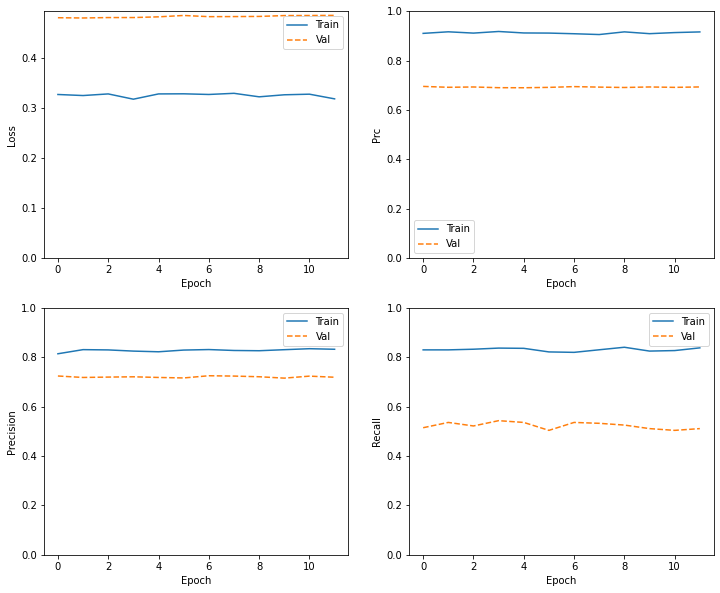

In [16]:
plot_metrics(baseline_history)

### Evaluate metrics

In [17]:
train_predictions_baseline = model.predict(train_generator, batch_size=batch_size,verbose=1)
valid_predictions_baseline = model.predict(valid_generator, batch_size=batch_size,verbose=1)
test_predictions_baseline = model.predict(test_generator, batch_size=test_generator.samples, verbose=1)

660/660 [==============================] - 11s 17ms/step


In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    # show numbers
    sns.heatmap(cm, annot=True, fmt="d", ax=ax[0])
    ax[0].set_title('Confusion matrix @{:.2f}'.format(p))
    ax[0].set_ylabel('Actual label')
    ax[0].set_xlabel('Predicted label')
    # show %
    cmp = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cmp, annot=True, fmt=".3f", 
                xticklabels=[f"pred_{c}" for c in train_generator.class_indices], 
                yticklabels=[f"true_{c}" for c in train_generator.class_indices],
                cmap="Blues",
                ax=ax[1])
    ax[1].set_title('Confusion matrix @{:.2f}'.format(p))
    ax[1].set_ylabel('Actual')
    ax[1].set_xlabel('Predicted')

    print('Legitimate Benign Detected (True Negatives): ', cm[0][0])
    print('Fraudulent Benign Incorrectly Detected (False Positives): ', cm[0][1])
    print('Legitimate Malignant Detected (True Positives): ', cm[1][1])
    print('Fraudulent Malignant Incorrectly Detected (False Negatives): ', cm[1][0])
    print('Total Incorrectly Detected: ', np.sum(cm[0][1]+cm[1][0]),' out of ',np.sum(cm))

loss :  0.47932368516921997
tp :  150.0
fp :  59.0
tn :  301.0
fn :  130.0
accuracy :  0.7046874761581421
precision :  0.7177033424377441
recall :  0.5357142686843872
auc :  0.8435367345809937
prc :  0.6920557022094727

Legitimate Benign Detected (True Negatives):  304
Fraudulent Benign Incorrectly Detected (False Positives):  56
Legitimate Malignant Detected (True Positives):  235
Fraudulent Malignant Incorrectly Detected (False Negatives):  65
Total Incorrectly Detected:  121  out of  660


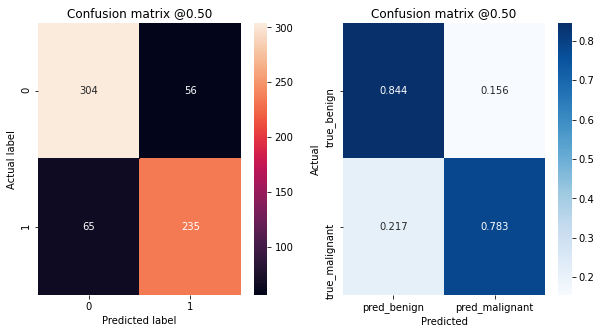

In [19]:
baseline_results = model.evaluate(valid_generator, steps=valid_generator.samples // batch_size, verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()
plot_confusion_matrix(test_generator.labels, test_predictions_baseline, 0.5)

### Plot the ROC

In [20]:
from sklearn.metrics import roc_curve, auc

def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    roc_auc = auc(fp, tp)
    plt.plot(100*fp, 100*tp, label=name+' (area = %0.2f)' % roc_auc, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
#     plt.xlim([-0.5,20])
#     plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

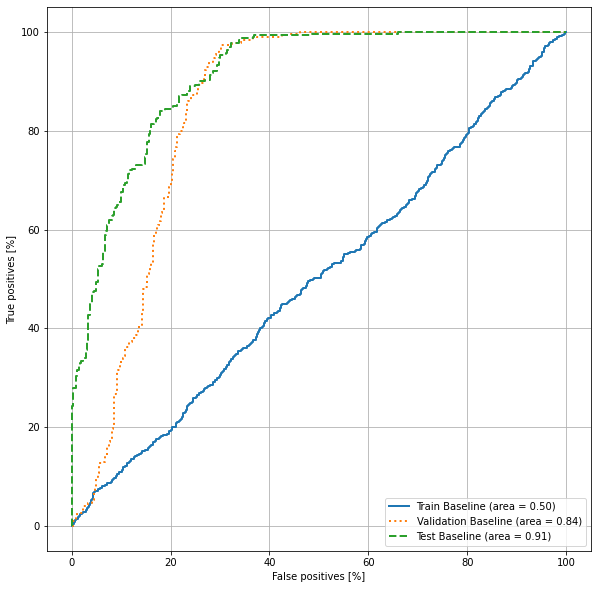

In [21]:
plot_roc("Train Baseline", train_generator.labels, train_predictions_baseline, color=colors[0])
plot_roc("Validation Baseline", valid_generator.labels, valid_predictions_baseline, color=colors[1], linestyle='dotted')
plot_roc("Test Baseline", test_generator.labels, test_predictions_baseline, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

### Plot the PRC

In [22]:
from sklearn.metrics import precision_recall_curve

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

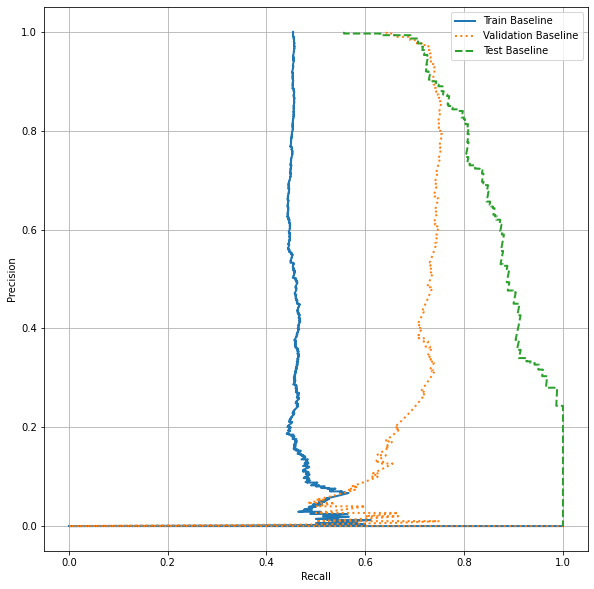

In [23]:
plot_prc("Train Baseline", train_generator.labels, train_predictions_baseline, color=colors[0])
plot_prc("Validation Baseline", valid_generator.labels, valid_predictions_baseline, color=colors[1], linestyle='dotted')
plot_prc("Test Baseline", test_generator.labels, test_predictions_baseline, color=colors[2], linestyle='--')
plt.legend(loc='upper right')

### Classification Report

In [24]:
from sklearn.metrics import classification_report

def show_classification_report(labels, predictions, p=0.5, **kwargs):
    print(classification_report(labels, predictions > p, **kwargs))

In [25]:
show_classification_report(test_generator.labels,test_predictions_baseline,p=0.5,target_names=['benign','malignant'])

              precision    recall  f1-score   support

      benign       0.82      0.84      0.83       360
   malignant       0.81      0.78      0.80       300

    accuracy                           0.82       660
   macro avg       0.82      0.81      0.81       660
weighted avg       0.82      0.82      0.82       660



## Class Weights

In [ ]:
train_generator.class_indices

In [ ]:
# compute 'benign': 0
neg = np.unique(train_generator.classes, return_counts=True)[1][0] + \
    np.unique(valid_generator.classes, return_counts=True)[1][0] + \
    np.unique(test_generator.classes, return_counts=True)[1][0]
# compute 'malignant': 1
pos = np.unique(train_generator.classes, return_counts=True)[1][1] + \
    np.unique(valid_generator.classes, return_counts=True)[1][1] + \
    np.unique(test_generator.classes, return_counts=True)[1][1]
#
total = neg + pos

print('Total examples: ', total)
print(' benign: ', neg)
print(' malignant: ', pos)

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

### Train Model with Class Weights

In [27]:
model = make_model()
model.load_weights(initial_weights)
# model = make_model(output_bias=initial_bias)
weighted_history = model.fit(train_generator,
                             steps_per_epoch = train_generator.samples // batch_size,
                             validation_data = valid_generator,
                             validation_steps = valid_generator.samples // batch_size,
                             epochs=epochs,
                             callbacks=[early_stopping, checkpoint, reduce_plateau],
                             # input class weights
                             class_weight=class_weight,
                             verbose=2)

### Save Model

In [57]:
action = input('Action: Save / Load / Check ')
print('Action: ', action)

Action: Save / Load / Checkhelp
Action:  help


In [56]:
from keras.models import load_model

model_name = 'weighted'

if(action == 'Save'):
    print('Saving Model....')
    model.save('./models/'+ model_name +'.h5')
elif(action == 'Load'):
    print('Loading Model...')
    model = load_model('./models/'+ model_name +'.h5')
elif(action == 'Check'):
    print('Checking Model...')
    reconstructed_model = load_model('./models/'+ model_name +'.h5')
    np.testing.assert_allclose(
        model.predict(test_generator,verbose=1), 
        reconstructed_model.predict(test_generator,verbose=1)
    )
else:
    print('No Action')

No Action


### Check training history

In [ ]:
plot_metrics(weighted_history)

### Evaluate metrics

In [29]:
train_predictions_weighted = model.predict(train_generator, batch_size=batch_size,verbose=1)
valid_predictions_weighted = model.predict(valid_generator, batch_size=batch_size,verbose=1)
test_predictions_weighted = model.predict(test_generator, batch_size=test_generator.samples, verbose=1)

660/660 [==============================] - 11s 17ms/step


loss :  0.46705061197280884
tp :  199.0
fp :  72.0
tn :  288.0
fn :  81.0
accuracy :  0.760937511920929
precision :  0.7343173623085022
recall :  0.7107142806053162
auc :  0.8440029621124268
prc :  0.6958587765693665

Legitimate Benign Detected (True Negatives):  280
Fraudulent Benign Incorrectly Detected (False Positives):  80
Legitimate Malignant Detected (True Positives):  262
Fraudulent Malignant Incorrectly Detected (False Negatives):  38
Total Incorrectly Detected:  118  out of  660


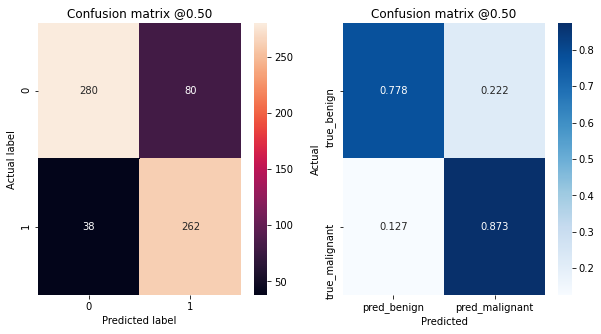

In [30]:
weighted_results = model.evaluate(valid_generator, steps=valid_generator.samples // batch_size, verbose=0)

for name, value in zip(model.metrics_names, weighted_results):
    print(name, ': ', value)
print()
plot_confusion_matrix(test_generator.labels, test_predictions_weighted, 0.5)

### Plot the ROC

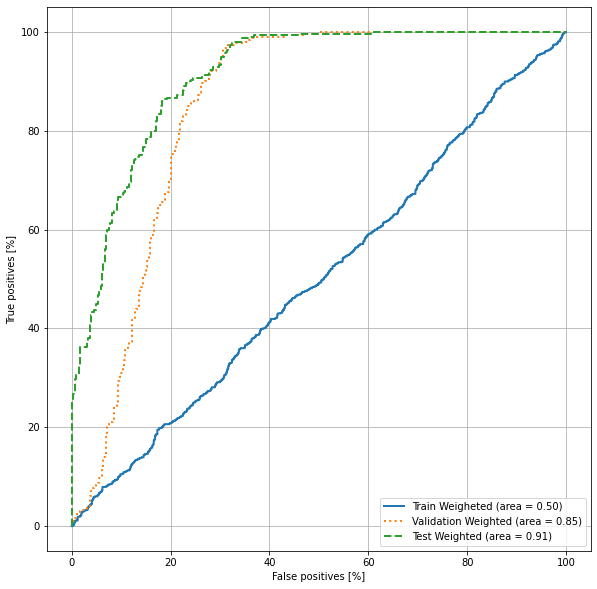

In [31]:
plot_roc("Train Weigheted", train_generator.labels, train_predictions_weighted, color=colors[0])
plot_roc("Validation Weighted", valid_generator.labels, valid_predictions_weighted, color=colors[1], linestyle='dotted')
plot_roc("Test Weighted", test_generator.labels, test_predictions_weighted, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

### Plot the PRC

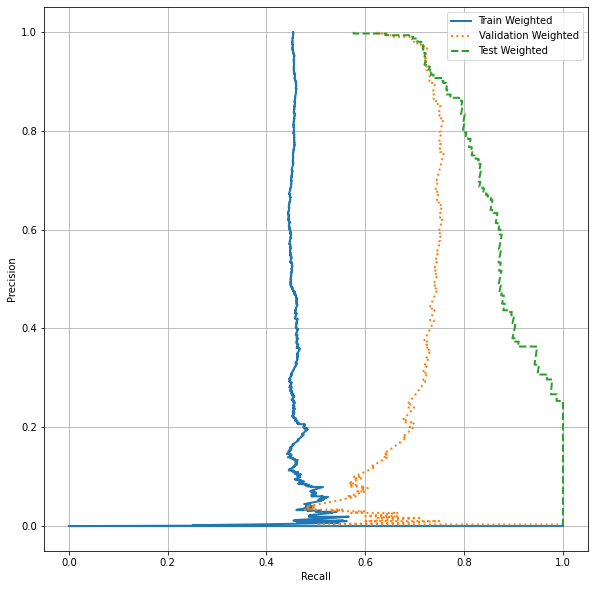

In [32]:
plot_prc("Train Weighted", train_generator.labels, train_predictions_weighted, color=colors[0])
plot_prc("Validation Weighted", valid_generator.labels, valid_predictions_weighted, color=colors[1], linestyle='dotted')
plot_prc("Test Weighted", test_generator.labels, test_predictions_weighted, color=colors[2], linestyle='--')
plt.legend(loc='upper right')

### Classification Report

In [33]:
show_classification_report(
    test_generator.labels,
    test_predictions_weighted,
    p=0.5,
    target_names=['benign','malignant'])

              precision    recall  f1-score   support

      benign       0.88      0.78      0.83       360
   malignant       0.77      0.87      0.82       300

    accuracy                           0.82       660
   macro avg       0.82      0.83      0.82       660
weighted avg       0.83      0.82      0.82       660



## Oversampling

N/A

## Test random examples